# Deep Clustering for Financial Market Segmentation

### Un enfoque de aprendizaje profundo no supervisado para el agrupamiento de clientes de tarjetas de crédito

Con el avance del aprendizaje profundo no supervisado, la red neuronal Autoencoder ahora se usa con frecuencia para la reducción de alta dimensionalidad (por ejemplo, un conjunto de datos con miles o más características). Autoencoder también se puede combinar con aprendizaje supervisado (por ejemplo, Random Forest) para formar un método de aprendizaje semisupervisado. Recientemente se publicó un método de agrupamiento integrado profundo (DEC) [1]. Combina autoencoder con K-means y otras técnicas de aprendizaje automático para el agrupamiento en lugar de la reducción de dimensionalidad. La implementación original de DEC se basa en Caffe.

El resto de este cuaderno está organizado de la siguiente manera:

* Preparación de datos
* Implementación del método DEC en Keras
* Resumen

### Import packages

In [1]:
from time import time
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import keras.metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\NJE_1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Preparación de datos
En esta sección se describen los pasos comunes de preprocesamiento de datos necesarios para la agrupación.

### 1.1 Carga de datos
Una vez que el conjunto de datos de la tarjeta de crédito en Kaggle [5] se haya descargado en una máquina local, se puede cargar en Pandas DataFrame de la siguiente manera:

In [1]:
np.random.seed(10) ### Para la selección aleatoria, vamos a utilizar la semilla 10.
data = pd.read_csv('./CC GENERAL.csv')
data.head()

NameError: name 'np' is not defined

In [ ]:
# ¿Cuántas columnas (variables) tenemos?
print(data.columns)
print("# of columns: " + str(len(data.columns)))

### 1.2 Selección de características 
En el DataFrame anterior se puede ver que el campo CUST_ID es único para cada registro de datos de cliente. Este campo con valores únicos no es útil para la agrupación y, por lo tanto, se puede descartar:

In [4]:
data_x = data.drop(['CUST_ID'], axis=1)

### 1.3 Re-escalado de las características
También se puede ver en el DataFrame que los rangos de valores son muy diferentes para los distintos campos o características. Es bien sabido que **K-means es sensible a la escala de los valores de las características porque utiliza la distancia euclidiana como métrica de similitud**. Para evitar este problema, los valores de todas las características se reescalan en el rango de [0, 1]:

In [5]:
numeric_columns = data_x.columns.values.tolist()
scaler = MinMaxScaler() 
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,NaN,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


### 1.4 Tratando los datos nulos
El siguiente código sirve para comprobar si faltan datos en el conjunto de datos:

In [6]:
data_x.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

La tabla anterior muestra que falta un registro CREDIT_LIMIT y 313 MINIMUM_PAYMENTS. En este caso, tiene sentido completar los datos faltantes con ceros:

In [7]:
data_x.fillna(0, inplace=True)

# 2. Implementación del método DEC en Keras

* Paso 1: Estimación del número de clústeres
* Paso 2: Creación y entrenamiento de un modelo K-means
* Paso 3: Creación y entrenamiento de un autocodificador
* Paso 4: Implementación del etiquetado suave DEC
* Paso 5: Creación de un nuevo modelo DEC
* Paso 6: Entrenamiento del nuevo modelo DEC
* Paso 7: Uso del modelo DEC entrenado para predecir clases de agrupamiento
* Paso 8: Refinamiento conjunto del modelo DEC
* Paso 9: Uso del modelo DEC refinado para predecir clases de agrupamiento
* Paso 10: Comparación con K-means

### 2.1 Estimación del número de clústeres
Como se describió anteriormente, el método DEC combina Autoencoder con K-means y otras técnicas de aprendizaje automático. Para entrenar un modelo K-means, **se requiere un número estimado de clústeres**. El número de clústeres se estima en este caso explorando los valores de silueta de diferentes ejecuciones del modelo K-means:

In [8]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters)
    preds = clusterer.fit_predict(data_x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.3867190566170049)
For n_clusters = 3, Kmeans silhouette score is 0.37239144184726336)
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683)
For n_clusters = 5, Kmeans silhouette score is 0.31915663889137763)
For n_clusters = 6, Kmeans silhouette score is 0.3342736587310193)
For n_clusters = 7, Kmeans silhouette score is 0.2975978165011552)
For n_clusters = 8, Kmeans silhouette score is 0.3164670586570084)
For n_clusters = 9, Kmeans silhouette score is 0.3343682925437562)


Un valor de silueta mide la similitud de un registro de datos con su propio grupo (cohesión) en comparación con otros grupos. El valor de silueta varía de −1 a +1, donde un valor alto indica que el registro de datos coincide bien con su propio grupo y no coincide bien con sus grupos vecinos.

Los valores de silueta anteriores indican que las dos primeras opciones de la cantidad de grupos son 2 y 3. Para el propósito de la clase, se elige la cantidad de grupos de 3.

### 2.2 Creación y entrenamiento del modelo K-means
Una vez que se determina la cantidad de clústeres, se puede crear un modelo K-means:

In [9]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
y_pred_kmeans = kmeans.fit_predict(data_x)

In [10]:
x = data_x.values
x.shape

(8950, 17)

### 2.3 Creación y entrenamiento de un autoencoder
Además de K-means, también se requiere un autoencoder en el algoritmo DEC [1]. La siguiente función sirve para crear un autocodificador:

In [11]:
def autoencoder(dims,act='relu', init='glorot_uniform'):
    """
    Modelo de autoencoder simétrico completamente conectado.

    dims: lista de los tamaños de las capas del encoder como [500, 500, 2000, 10].
dims[0] es la dimensión de entrada, dims[-1] es el tamaño de la capa oculta latente.

    act: función de activación

    return:
(autoencoder_model, encoder_model): modelo del autoencoder y modelo del encoder
    """

    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act,  kernel_initializer=init, name='encoder_%d' % i)(x)
    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)
    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

Un modelo de autoencoder se crea de la siguiente manera:

In [12]:
n_epochs   = 100
batch_size = 128
dims = [x.shape[-1], 500, 500, 2000, 10] 
## VarianceScaling
### Es una estrategia de inicialización de peso que se utiliza para ayudar con el entrenamiento de redes neuronales. 
### Escala los pesos iniciales de las capas en función de la varianza de las entradas, lo que
### puede ayudar a mantener un flujo de gradiente saludable a través de la red y potencialmente mejorar el rendimiento del entrenamiento.
init_ = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform') 
pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)

In [13]:
pretrain_epochs = n_epochs
batch_size = batch_size
autoencoder, encoder = autoencoder(dims, init=init_)

Como se describe en [1], los tamaños de las capas [500, 500, 2000, 10] se eligen como una configuración genérica de la red neuronal del autoencoder para cualquier conjunto de datos.

El diagrama del modelo de encoder resultante se puede crear de la siguiente manera:

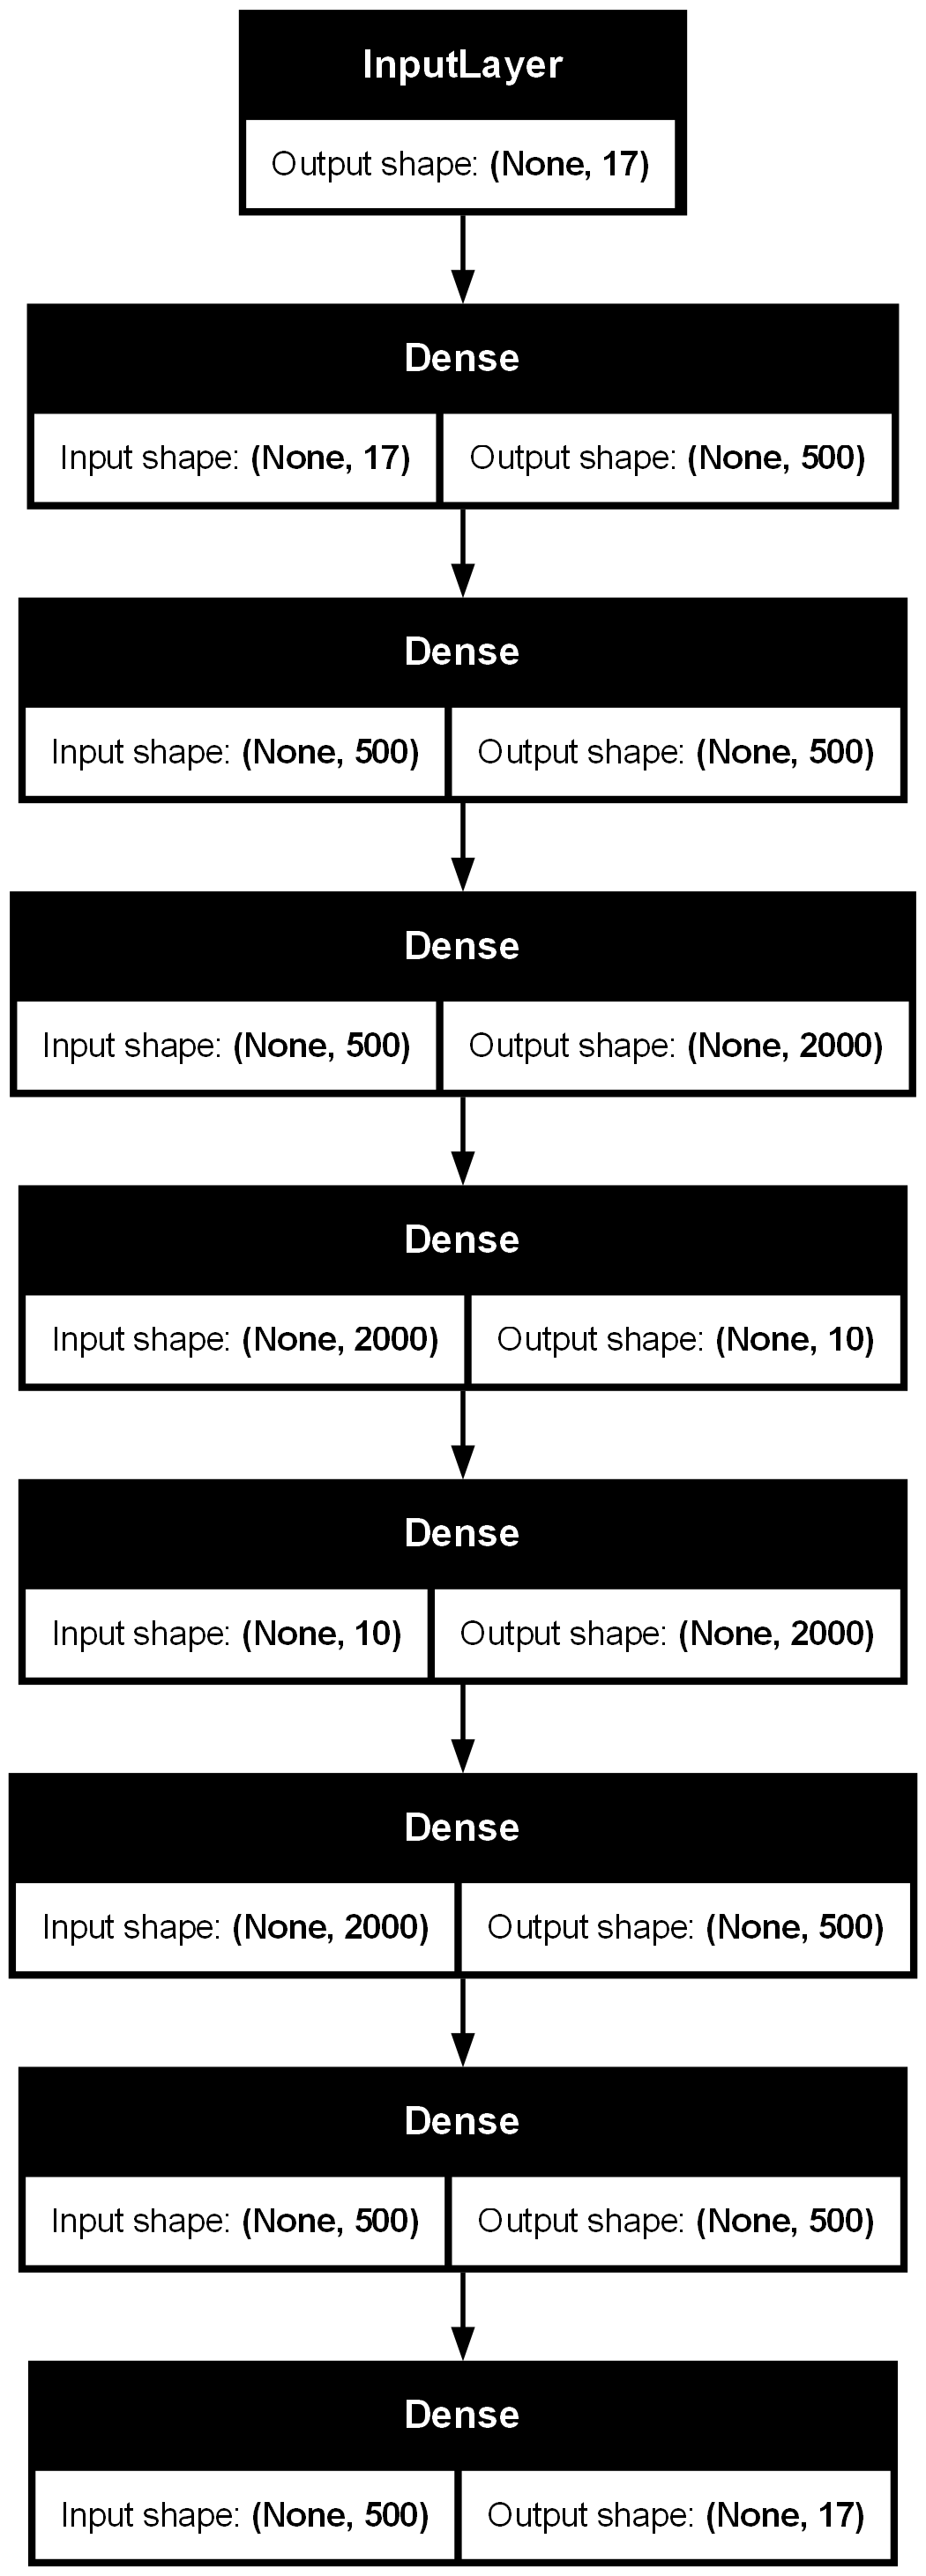

In [16]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(autoencoder,to_file="./AutoEncoder.png",show_shapes=True)
Image(filename='./AutoEncoder.png')


El autoencoder se entrena de la siguiente manera:

In [23]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x,x, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.6165e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6784e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5388e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5755e-04
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3882e-04
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5441e-04
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5053e-04
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6131e-04
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6468e-04
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4710e-04
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5877e-04
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4063e-04
Epoch 13/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5310e-04
Epoch 14/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2121e-04
E

Los pesos del autocodificador entrenado se guardan para su uso posterior:

In [29]:
autoencoder.save_weights('./ae_W.weights.h5')
autoencoder.load_weights('./ae_W.weights.h5')

### 2.4 Implementación del etiquetado suave DEC
Uno de los componentes clave del método DEC [1] es el etiquetado suave, es decir, la asignación de una clase estimada a cada una de las muestras de datos de tal forma que pueda refinarse iterativamente. Para ello, de manera similar a [2], se define una nueva clase ClusteringLayer:

In [47]:
class ClusteringLayer(Layer):
    '''
    La capa de agrupamiento convierte la muestra de entrada (característica) en una etiqueta flexible, es decir, 
    un vector que representa la probabilidad de que la muestra pertenezca a cada grupo. La probabilidad se calcula 
    con la distribución t de Student.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        Distribución t de Student, como se utiliza en el algoritmo t-SNE.
        Mide la similitud entre el punto incrustado z_i y el centroide µ_j.
        q_ij = 1/(1+dist(x_i, µ_j)^2), luego se normaliza.
        q_ij se puede interpretar como la probabilidad de asignar la muestra i al conglomerado j.
        (es decir, una asignación flexible)

        Input: la variable que contiene los datos, forma=(n_muestras, n_características)

        Return: distribución t de Student o etiquetas flexibles para cada muestra. forma=(n_muestras, n_conglomerados)
        '''
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 2.5 Creación de un nuevo modelo DEC
Una vez definida la capa de etiquetado flexible, se puede utilizar para formar un modelo DEC de la siguiente manera:

In [48]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

Se puede crear un diagrama del nuevo modelo DEC como se muestra a continuación:

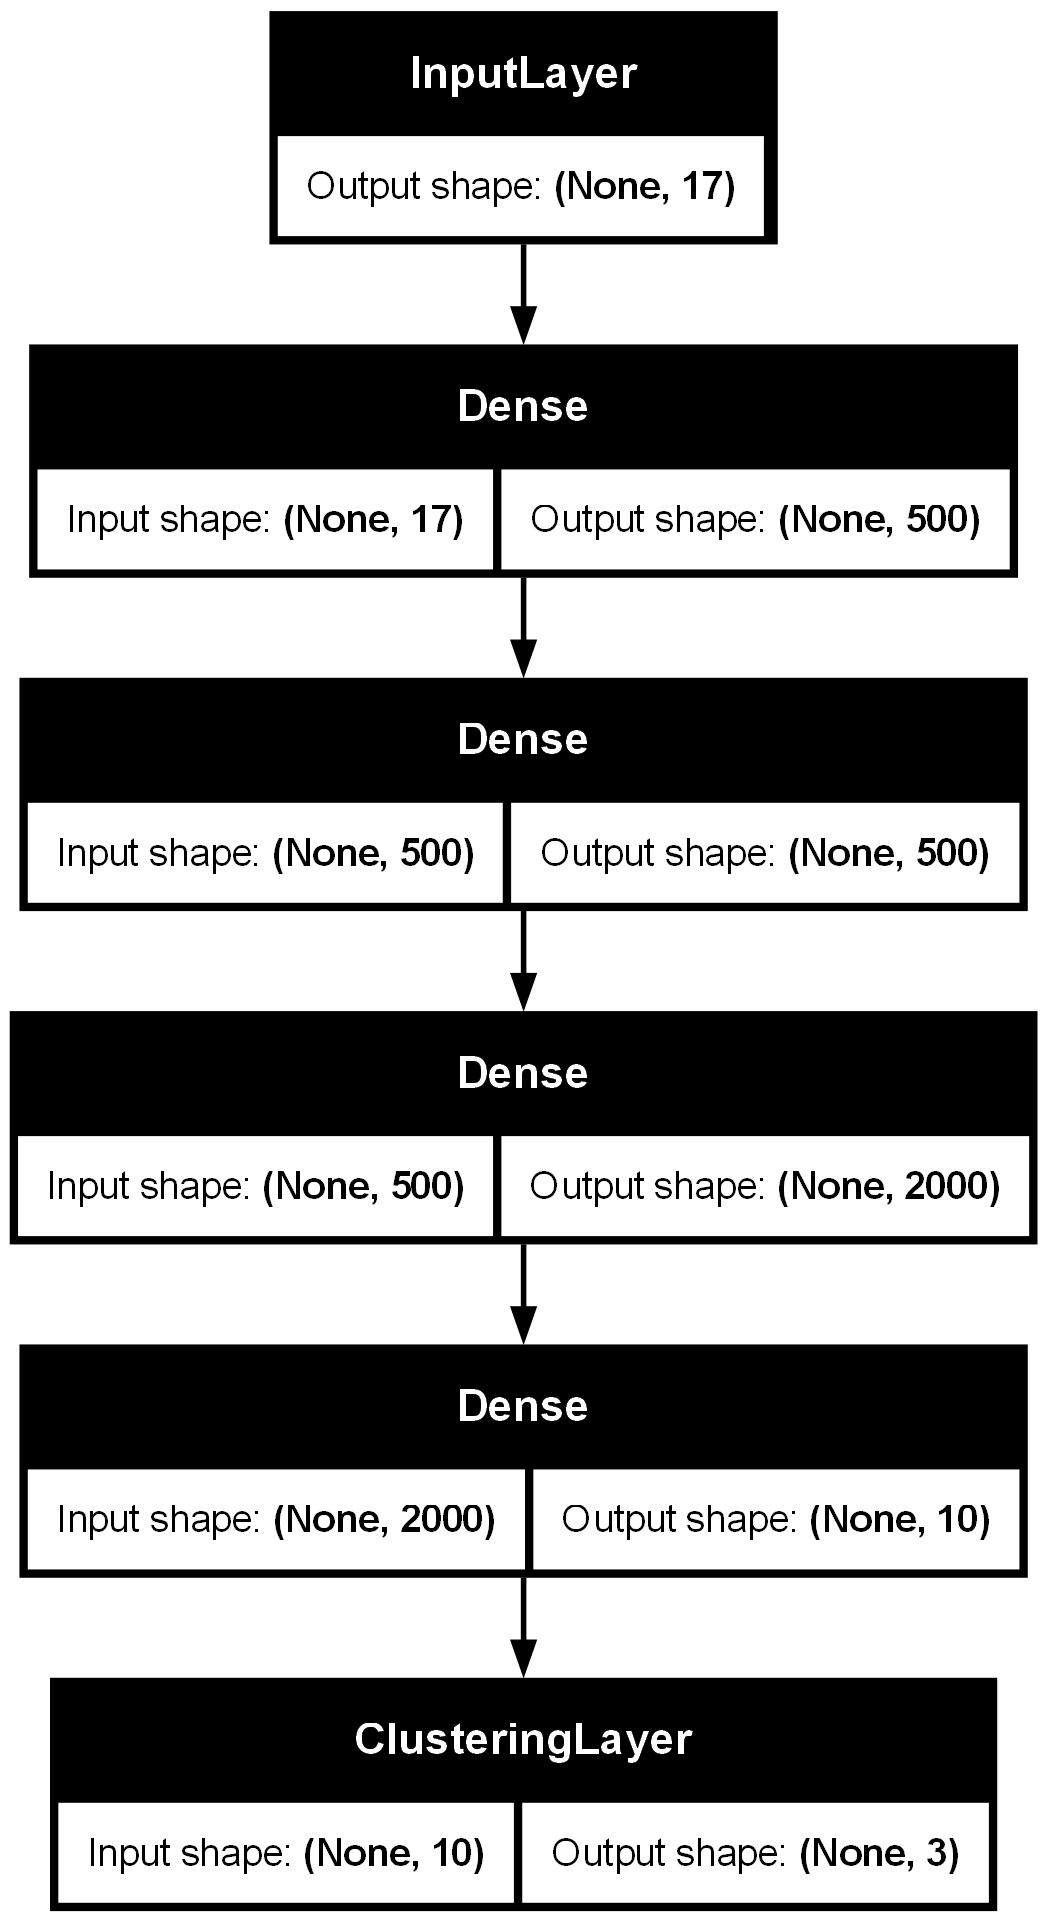

In [33]:
plot_model(model, to_file='./model.png', show_shapes=True)
Image(filename='./model.png')

El nuevo modelo DEC se puede compilar de la siguiente manera:

In [49]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### 2.6 Entrenamiento del nuevo modelo DEC: agrupamiento profundo
El nuevo modelo DEC se entrena de forma iterativa:

In [50]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T
loss = 0
index = 0
maxiter = 1000 
update_interval = 100 
tol = 0.001 # tolerance threshold to stop training
index_array = np.arange(x.shape[0])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Como se describe en [1], el procedimiento de entrenamiento anterior refina iterativamente los clústeres aprendiendo de las asignaciones de alta confianza con la ayuda de la función de distribución objetivo auxiliar target_distribution(). Específicamente, el modelo DEC se entrena haciendo coincidir la asignación suave con la distribución objetivo. Para este fin, en el modelo DEC la función objetivo/pérdida se define como una pérdida de divergencia de Kullback-Leibler (KL) entre las asignaciones suaves y la distribución auxiliar.

Los pesos del modelo entrenado se guardan para su uso posterior:

In [52]:
model.save_weights('./DEC_model_final.weights.h5')
model.load_weights('./DEC_model_final.weights.h5')

### 2.7 Uso del modelo DEC entrenado para predecir clases de agrupamiento
Una vez que se entrena el modelo DEC, se puede utilizar para predecir clases de agrupamiento de la siguiente manera:

In [54]:
## Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q) # Actualizar la distribución de destino auxiliar p

# evaluar el rendimiento del clustering
y_pred = q.argmax(1)

In [57]:
data_all = data_x.copy()
data_all['cluster'] = y_pred
data_all.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0,1
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0,1
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0,2
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0,1
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0,1


In [58]:
data_all['cluster'].value_counts()

1    4130
0    2979
2    1841
Name: cluster, dtype: int64

El siguiente código se puede utilizar para usar t-SNE para integrar el conjunto de datos en un espacio bidimensional y luego usar la codificación de colores de las etiquetas de agrupamiento previstas para visualizar el resultado de agrupamiento previsto:

In [59]:
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x)

x_embedded.shape

(8950, 2)

In [61]:
# For n_clusters = 3, Kmeans silhouette score is 0.3723536590701517)
# For n_clusters = 4, Kmeans silhouette score is 0.3215079773343314)
# For n_clusters = 10, Kmeans silhouette score is 0.34194939183619716)
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (x, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Kmeans silhouette score is 0.372350277731719)


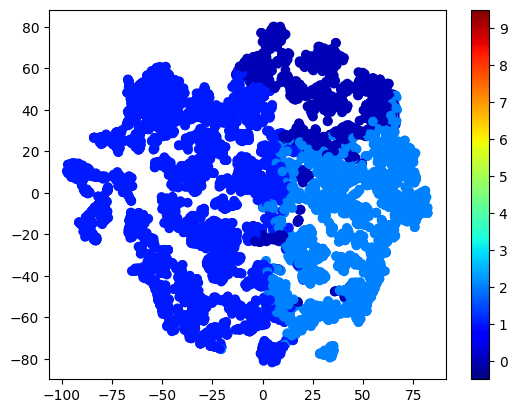

In [63]:

### Figure 1: Clustering of the new DEC model with silhouette score of 0.3723
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [62]:
# For n_clusters = 3, Deep clustering silhouette score is 0.29138845064227953)
# For n_clusters = 4, Deep clustering silhouette score is 0.28032271072644543)
# For n_clusters = 10, Deep clustering silhouette score is 0.19216022223500343)
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.34065099513042535)


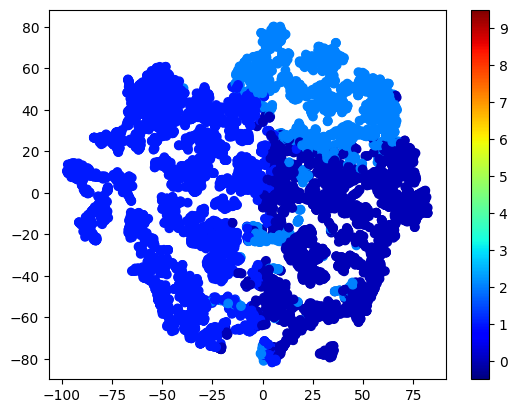

In [64]:
### Figure 2: Clustering of the new DEC model with silhouette score of 0.3406
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [66]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.3867190566170049)
For n_clusters = 3, Kmeans silhouette score is 0.3722174916129305)
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683)
For n_clusters = 5, Kmeans silhouette score is 0.3195084713077689)
For n_clusters = 6, Kmeans silhouette score is 0.3342310827672774)
For n_clusters = 7, Kmeans silhouette score is 0.33778076322284445)
For n_clusters = 8, Kmeans silhouette score is 0.3163957250325844)
For n_clusters = 9, Kmeans silhouette score is 0.33435939368759066)


### References

1. J. Xie, R. Girshick, A. Farhadi, Unsupervised Deep Embedding for Clustering Analysis, May 24, 2016

2. Chengwei, How to do Unsupervised Clustering with Keras

3. Kaggle Credit Card Dataset for Clustering

4. Y. Zhang, Jupyter notebook in Github
5. Source of data: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata